In [3]:
%matplotlib inline

In [4]:
from __future__ import print_function, division
import os
import csv
import torch
import cv2
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

plt.ion()

In [5]:
img_dir = 'data/images'
csv_filename = 'data/head_tail_results.csv'
# csv_filename = 'Batch_3113691_batch_results.csv'
# csv_filename = 'Updated_Batch_3084800_batch_results.csv'
# csv_filename = 'Batch_181066_batch_results.csv'
IMG_NAME = 'img_name'
CLASS = 'class'
COORDINATES = 'coordinates'

def url_to_filename(img_url):
    return img_url.split('/')[-1]

def url_to_class(img_url):
    return img_url.split('/')[4].split('_')[0]

def read_csv(csv_filename):
    with open(csv_filename, 'r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        data = []
        for row in csv_reader:
            annotation_data = eval(row['Answer.annotation_data'])
            for d in annotation_data:
                processed_data = preprocess(d)
                if processed_data is not None:
                    data.append(processed_data)
    return pd.DataFrame(data)

def preprocess(datum):
    if datum['head'] == 'out of frame' or datum['tail'] == 'out of frame':
        return
    new_datum = {}
    new_datum[IMG_NAME] = url_to_filename(datum['url'])
    new_datum[CLASS] = url_to_class(datum['url'])
    new_datum[COORDINATES] = [datum['head']['relative_x'],
                              datum['head']['relative_y'],
                              datum['tail']['relative_x'],
                              datum['tail']['relative_y']]
    
    return new_datum

In [10]:
import urllib
import time

def download_img(csv_filename, img_dir):
    if not os.path.isdir(img_dir):
        os.makedirs(img_dir)
    with open(csv_filename, 'r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for i, row in enumerate(csv_reader):
            annotation_data = eval(row['Answer.annotation_data'])
            for d in annotation_data:
                img_url, img_name = d['url'], url_to_filename(d['url'])
                img_file = os.path.join(img_dir, img_name)
                if not os.path.isfile(img_file):
                    urllib.urlretrieve(img_url, img_file)
#             if i % 1000 == 0:
#                 print(i)

download_img(csv_filename, img_dir)

In [6]:
# # change old annotation data frame to the lastest version and save to csv
# def update_old(csv_filename):
#     df = pd.read_csv(csv_filename)
#     for i, row in df.iterrows():
#         ann_data = eval(row['Answer.annotation_data'])
#         for d in ann_data:
#             img_file = os.path.join(img_dir, 
#                                     url_to_filename(d['url']))
#             img = cv2.imread(img_file)
#             height, width = img.shape[:2]
#             turk_width = 200
#             turk_height = int(round(height * turk_width / width))
#             for p in ['head', 'tail']:
#                 if d[p] == 'out of frame':
#                     continue
#                 d[p]['click_x'], d[p]['click_y'] = d[p]['x'], d[p]['y']
#                 d[p]['relative_x'] = d[p]['x'] / turk_width
#                 d[p]['relative_y'] = d[p]['y'] / turk_height
#                 d[p]['width'], d[p]['height'] = turk_width, turk_height
#                 del d[p]['x'], d[p]['y']
#             del d['width'], d['height']
#         df.loc[i, 'Answer.annotation_data'] = str(ann_data)
#     return df

# new_df = update_old('Batch_3084800_batch_results.csv')
# new_df.to_csv('Updated_' + csv_filename)

In [7]:
def data_filter(data):
    grouped = data.groupby(IMG_NAME)
    coordinates_group = grouped[COORDINATES].apply(list).apply(lambda x: np.median(x, axis=0))
    class_group = grouped[CLASS].apply(list).apply(lambda x: x[0])
    data = pd.concat([coordinates_group, class_group], axis=1)
    return data.reset_index()

In [27]:
data = read_csv(csv_filename)
data = data_filter(data)
len(data)

89159

In [26]:
n = 3
img_name = data.loc[n, IMG_NAME]
coordinates = data.loc[n, COORDINATES]
cls = data.loc[n, CLASS]
print(img_name)
print(coordinates)
print(cls)

SPCBench-1487372267-003842-004-196-1552-88-80-_rawcolor.png
[0.56, 0.6923076923076923, 0.45, 0.38461538461538464]
20170217


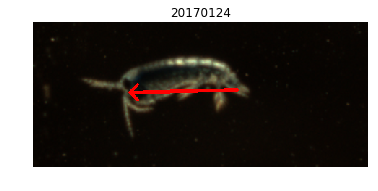

In [14]:
def show_arrow(image, coordinates, cls):
    image = np.copy(image)
    height, width = image.shape[:2]
    head = (int(coordinates[0] * width), int(coordinates[1] * height))
    tail = (int(coordinates[2] * width), int(coordinates[3] * height))
    cv2.arrowedLine(image, tail, head, (255, 0, 0), 3)
    plt.imshow(image)
    plt.axis('off')
    plt.title(cls)
    plt.pause(0.001)
    
plt.figure()
show_arrow(io.imread(os.path.join(img_dir, img_name)), coordinates, cls)
plt.show()

In [15]:
class PlanktonDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = data_filter(read_csv(csv_file))
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, 
                                self.data.loc[idx, IMG_NAME])
        image = io.imread(img_name)
        coordinates = self.data.loc[idx, COORDINATES]
        cls = self.data.loc[idx, CLASS]
        sample = {'image': image, 
                  'coordinates': np.asarray(coordinates), 
                  'cls': cls}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

0 (256, 240, 3) (4,)
123 (248, 416, 3) (4,)
246 (72, 168, 3) (4,)
369 (344, 296, 3) (4,)


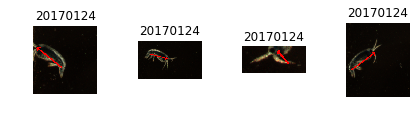

In [16]:
plankton_dataset = PlanktonDataset(csv_file=csv_filename,
                                   img_dir=img_dir)

fig = plt.figure()

step = 123
for i in range(0, len(plankton_dataset), step):
    sample = plankton_dataset[i]
    
    print(i, sample['image'].shape, sample['coordinates'].shape)
    
    ax = plt.subplot(1, 4, int(i / step) + 1)
    plt.tight_layout()
    ax.axis('off')
    show_arrow(**sample)
    
    if i == 3 * step:
        plt.show()
        break

In [17]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, coordinates, cls = sample['image'], sample['coordinates'], sample['cls']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        
        image = cv2.resize(image, (new_w, new_h))
        
        return {'image': image, 'coordinates': coordinates, 'cls': cls}

In [18]:
# class RandomCrop(object):
#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         if isinstance(output_size, int):
#             self.output_size = (output_size, output_size)
#         else:
#             assert len(output_size) == 2
#             self.output_size = output_size
    
#     def __call__(self, sample):
#         image, coordinates, cls = sample['image'], sample['coordinates'], sample['cls']
        
#         h, w = image.shape[:2]
#         new_h, new_w = self.output_size
# #         min_h, min_w = abs(coordinates[3] - coordinates[1]), \
# #                        abs(coordinates[2] - coordinates[0])
        
# #         if new_h > min_h and new_w > min_w:
#         top = np.random.randint(0, h - new_h)
#         left = np.random.randint(0, w - new_w)

#         image = image[top:top + new_h,
#                       left:left + new_w]
#         coordinates = [(coordinates[0] - left / w) * w / new_w,
#                        (coordinates[1] - top / h) * h / new_h,
#                        (coordinates[2] - left / w) * w / new_w,
#                        (coordinates[3] - top / h) * h / new_h,]
        
# #         else:
# #             top = np.random.randint(0, min(coordinates[1], coordinates[3]))
# #             left = np.random.randint(0, min(coordinates[0], coordinates[2]))
# #             bottom = np.random.randint(max(coordinates[1], coordinates[3]), h)
# #             right = np.random.randint(max(coordinates[0], coordinates[2]), w)
            
# #             image = image[top:bottom, left:right]
# #             image = transform.resize(image, output_size)
            
# #             scale = 
#         return {'image': image, 'coordinates': coordinates, 'cls': cls}

In [19]:
class ToTensor(object):
    def __call__(self, sample):
        image, coordinates, cls = sample['image'], sample['coordinates'], sample['cls']
        
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 
                'coordinates': torch.from_numpy(coordinates), 
                'cls': cls}

In [20]:
class RandomHorizontalFlip(object):
    def __call__(self, sample):
        image, coordinates, cls = sample['image'], sample['coordinates'], sample['cls']
        
        if np.random.rand() > 0.5:
            image = image[:, ::-1, :].copy()
            coordinates = np.asarray([
                1 - coordinates[0], coordinates[1],
                1 - coordinates[2], coordinates[3]])
        
        return {'image': image, 'coordinates': coordinates, 'cls': cls}

In [21]:
class RandomVerticalFlip(object):
    def __call__(self, sample):
        image, coordinates, cls = sample['image'], sample['coordinates'], sample['cls']
        
        if np.random.rand() > 0.5:
            image = image[::-1, :, :].copy()
            coordinates = np.asarray([
                coordinates[0], 1 - coordinates[1],
                coordinates[2], 1 - coordinates[3]])
        
        return {'image': image, 'coordinates': coordinates, 'cls': cls}

In [22]:
class EmptyTransform(object):
    def __call__(self, sample):
        return sample

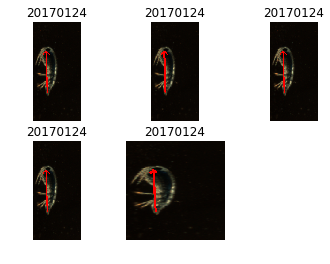

In [23]:
scale = Rescale(128)
hflip = RandomHorizontalFlip()
vflip = RandomVerticalFlip()
original = EmptyTransform()
composed = transforms.Compose([hflip, vflip, Rescale((224, 224))])

fig = plt.figure()
sample = plankton_dataset[2]
for i, tsfm in enumerate([original, scale, hflip, vflip, composed]):
    transformed_sample = tsfm(sample)
    
    ax = plt.subplot(2, 3, i + 1)
    ax.set_title(type(tsfm).__name__)
    show_arrow(**transformed_sample)

plt.show()

In [24]:
transformed_dataset = PlanktonDataset(csv_file=csv_filename,
                                      img_dir=img_dir,
                                      transform=transforms.Compose([
                                          Rescale((224, 224)),
                                          RandomHorizontalFlip(),
                                          RandomVerticalFlip(),
                                          ToTensor()
                                      ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), 
          sample['coordinates'].size(), 
          sample['cls'])
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([4]) 20170124
1 torch.Size([3, 224, 224]) torch.Size([4]) 20170124
2 torch.Size([3, 224, 224]) torch.Size([4]) 20170124
3 torch.Size([3, 224, 224]) torch.Size([4]) 20170124


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 4]) ['20170126', '20170223', '20170216', '20170223']
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 4]) ['20170303', '20170126', '20170516', '20170209']
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 4]) ['20170216', '20170303', '20170504', '20170209']
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 4]) ['20170124', '20170504', '20170207', '20170509']


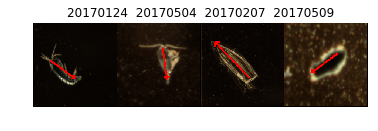

In [23]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

def show_arrow_batch(sample_batched):
    images_batch, coordinates_batch, cls_batch = \
        sample_batched['image'], sample_batched['coordinates'], sample_batched['cls']
    batch_size = len(images_batch)
    im_h, im_w = images_batch.size(2), images_batch.size(3)
    
    grid = utils.make_grid(images_batch)
    grid = grid.numpy().transpose((1, 2, 0))
    grid = grid.copy()
    
    for i in range(batch_size):
        hx, hy, tx, ty = coordinates_batch[i].numpy()
        head, tail = (int(tx * im_w + i * im_w), int(ty * im_h)), \
                     (int(hx * im_w + i * im_w), int(hy * im_h))
        cv2.arrowedLine(grid, tail, head, (255, 0, 0), 3)
    
    plt.imshow(grid)
    plt.title('  '.join(cls_batch))
    
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['coordinates'].size(),
          sample_batched['cls'])

    if i_batch == 3:
        plt.figure()
        show_arrow_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break